In [1]:
%load_ext autoreload
%autoreload 2

# Demonstration of image augmentation for FCU-Net
- based off of Joydeep's data augmentation, updated with s&p noise, shifting, and converting everything to numpy/cupy rather than tensorflow 
- there are some quirks regarding how he organized his tensors for doing ffts that i've left (for now), but which I can clean up once we know exactly how this will be used. 
- I also haven't ported over the elliptic transforms yet, but I'm planning on just grabbing those from py4dstem 
- this notebook gives a brief demo using a few images from the training set

In [2]:
import numpy as np
import cupy as cp
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import h5py 
import os 

from augment4D.augment import Image_Augmentation

# Helpers

In [3]:
def change_root_path(row, rot_path, unrot_path):
    '''
    changes the root path of '/data/...' to whatever the correct file path is while keeping the nested file structure

    row: pandas series
    rot_path: Path or str to the top level dir ml-ai-4dstem-main
    unrot_path: Path or str to the top level dir ml-ai-4dstem-main-unrotated
    '''
    # get the paths for sims and training datasets

    s_training = str(row.training_name)
    s_sim = str(row.filenameOutput)
    # check if its unrotated
    # if its not unrotated we need to set the path to rot_path
    if not row.rotation_type == 'unrotated':
        s_training = Path(s_training.replace('/data', rot_path))
        s_sim = Path(s_sim.replace('/data', rot_path))
    # if its unrotated we need to set to unrotated path
    else:
        s_training = Path(s_training.replace('/data', unrot_path))
        s_sim = Path(s_sim.replace('/data', unrot_path))

    row.training_name = s_training
    row.filenameOutput =  s_sim
    return row


# load some example data 
- same template as the demo .ipynb that Alex shared

In [4]:
unrot_path = '/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4dstem-main-unrotated'
rot_path = '/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4dstem-main'
dataframe_path = "/global/cfs/cdirs/m4269/FCU-Net_Data/full_dataframe_FCU-Net_data.pkl"

df_orig = pd.read_pickle(dataframe_path)
df = df_orig.apply(change_root_path, rot_path=rot_path, unrot_path=unrot_path, axis=1)
df = df[df.training_name.apply(os.path.exists)]
pd.set_option('display.max_columns', None)
df

mat_id    query_time  space_group_number space_group_symbol  \
0      mp-1186898  1.623736e+09                 187              P-6m2   
1      mp-1186898  1.623736e+09                 187              P-6m2   
2      mp-1186898  1.623736e+09                 187              P-6m2   
3       mp-554159  1.623736e+09                  20             C222_1   
4       mp-554159  1.623736e+09                  20             C222_1   
...           ...           ...                 ...                ...   
33295   mp-765191  1.623736e+09                  14             P2_1/c   
33296   mp-765191  1.623736e+09                  14             P2_1/c   
33297  mp-1220385  1.623736e+09                 153             P3_212   
33298  mp-1220385  1.623736e+09                 153             P3_212   
33299  mp-1220385  1.623736e+09                 153             P3_212   

      space_group_system pretty_formula full_formula  average_distance  \
0              hexagonal           RbYb       Rb1Yb1          4.515849   
1              hexagonal           RbYb       Rb1Yb1          4.515849   
2              hexagonal           RbYb       Rb1Yb1          4.515849   
3           orthorhombic      Li2BeSiO4  Li4Be2Si2O8          2.822708   
4           orthorhombic      Li2BeSiO4  Li4Be2Si2O8          2.822708   
...                  ...            ...          ...               ...   
33295         monoclinic         LiAgF4    Li4Ag4F16          3.477063   
33296         monoclinic         LiAgF4    Li4Ag4F16          3.477063   
33297           trigonal         NbSiGe    Nb3Si3Ge3          2.847669   
33298           trigonal         NbSiGe    Nb3Si3Ge3          2.847669   
33299           trigonal         NbSiGe    Nb3Si3Ge3          2.847669   

        density                                     atomic_numbers  \
0      3.606859                                           [37, 70]   
1      3.606859                                           [37, 70]   
2      3.606859                                           [37, 70]   
3      2.577862  [3, 3, 3, 3, 4, 4, 14, 14, 8, 8, 8, 8, 8, 8, 8...   
4      2.577862  [3, 3, 3, 3, 4, 4, 14, 14, 8, 8, 8, 8, 8, 8, 8...   
...         ...                                                ...   
33295  4.090207  [3, 3, 3, 3, 47, 47, 47, 47, 9, 9, 9, 9, 9, 9,...   
33296  4.090207  [3, 3, 3, 3, 47, 47, 47, 47, 9, 9, 9, 9, 9, 9,...   
33297  6.854208               [41, 41, 41, 14, 14, 14, 32, 32, 32]   
33298  6.854208               [41, 41, 41, 14, 14, 14, 32, 32, 32]   
33299  6.854208               [41, 41, 41, 14, 14, 14, 32, 32, 32]   

       average_atomic_number pymatgen_version                  script_name  \
0                  53.500000         2022.0.8  scrape_materials_project.py   
1                  53.500000         2022.0.8  scrape_materials_project.py   
2                  53.500000         2022.0.8  scrape_materials_project.py   
3                   7.000000         2022.0.8  scrape_materials_project.py   
4                   7.000000         2022.0.8  scrape_materials_project.py   
...                      ...              ...                          ...   
33295              14.333333         2022.0.8  scrape_materials_project.py   
33296              14.333333         2022.0.8  scrape_materials_project.py   
33297              29.000000         2022.0.8  scrape_materials_project.py   
33298              29.000000         2022.0.8  scrape_materials_project.py   
33299              29.000000         2022.0.8  scrape_materials_project.py   

       row_id  name                                  uuid  \
0          51  name  0003bd29-4cff-4172-88d5-ac7b61aab08c   
1          51  name  0003bd29-4cff-4172-88d5-ac7b61aab08c   
2          51  name  0003bd29-4cff-4172-88d5-ac7b61aab08c   
3         958  name  000675f8-59ef-4a57-94ec-a72059d9bc8d   
4         958  name  000675f8-59ef-4a57-94ec-a72059d9bc8d   
...       ...   ...                                   ...   
33295     878  name  ffa04d4

In [5]:
# select just some of the data as an example 
# row = df.iloc[0]
row = df[(df.mat_id == 'mp-1186898') & (df.probeSemiangle > 2) & (df.rotation_type == 'unrotated')].iloc[0]

In [6]:
# load the cbed patterns and probes 
with h5py.File(row.training_name, 'r') as f:
    print(f.keys())
    cbeds = f['dataMeas'][...]
    thicknesses = f['thicknesses'][...]
    probe = f['dataProbe'][...]

<KeysViewHDF5 ['dataMeas', 'dataPots', 'dataProbe', 'dataQz', 'qx', 'qy', 'qz', 'thicknesses']>


In [7]:
probe.shape

(256, 256)

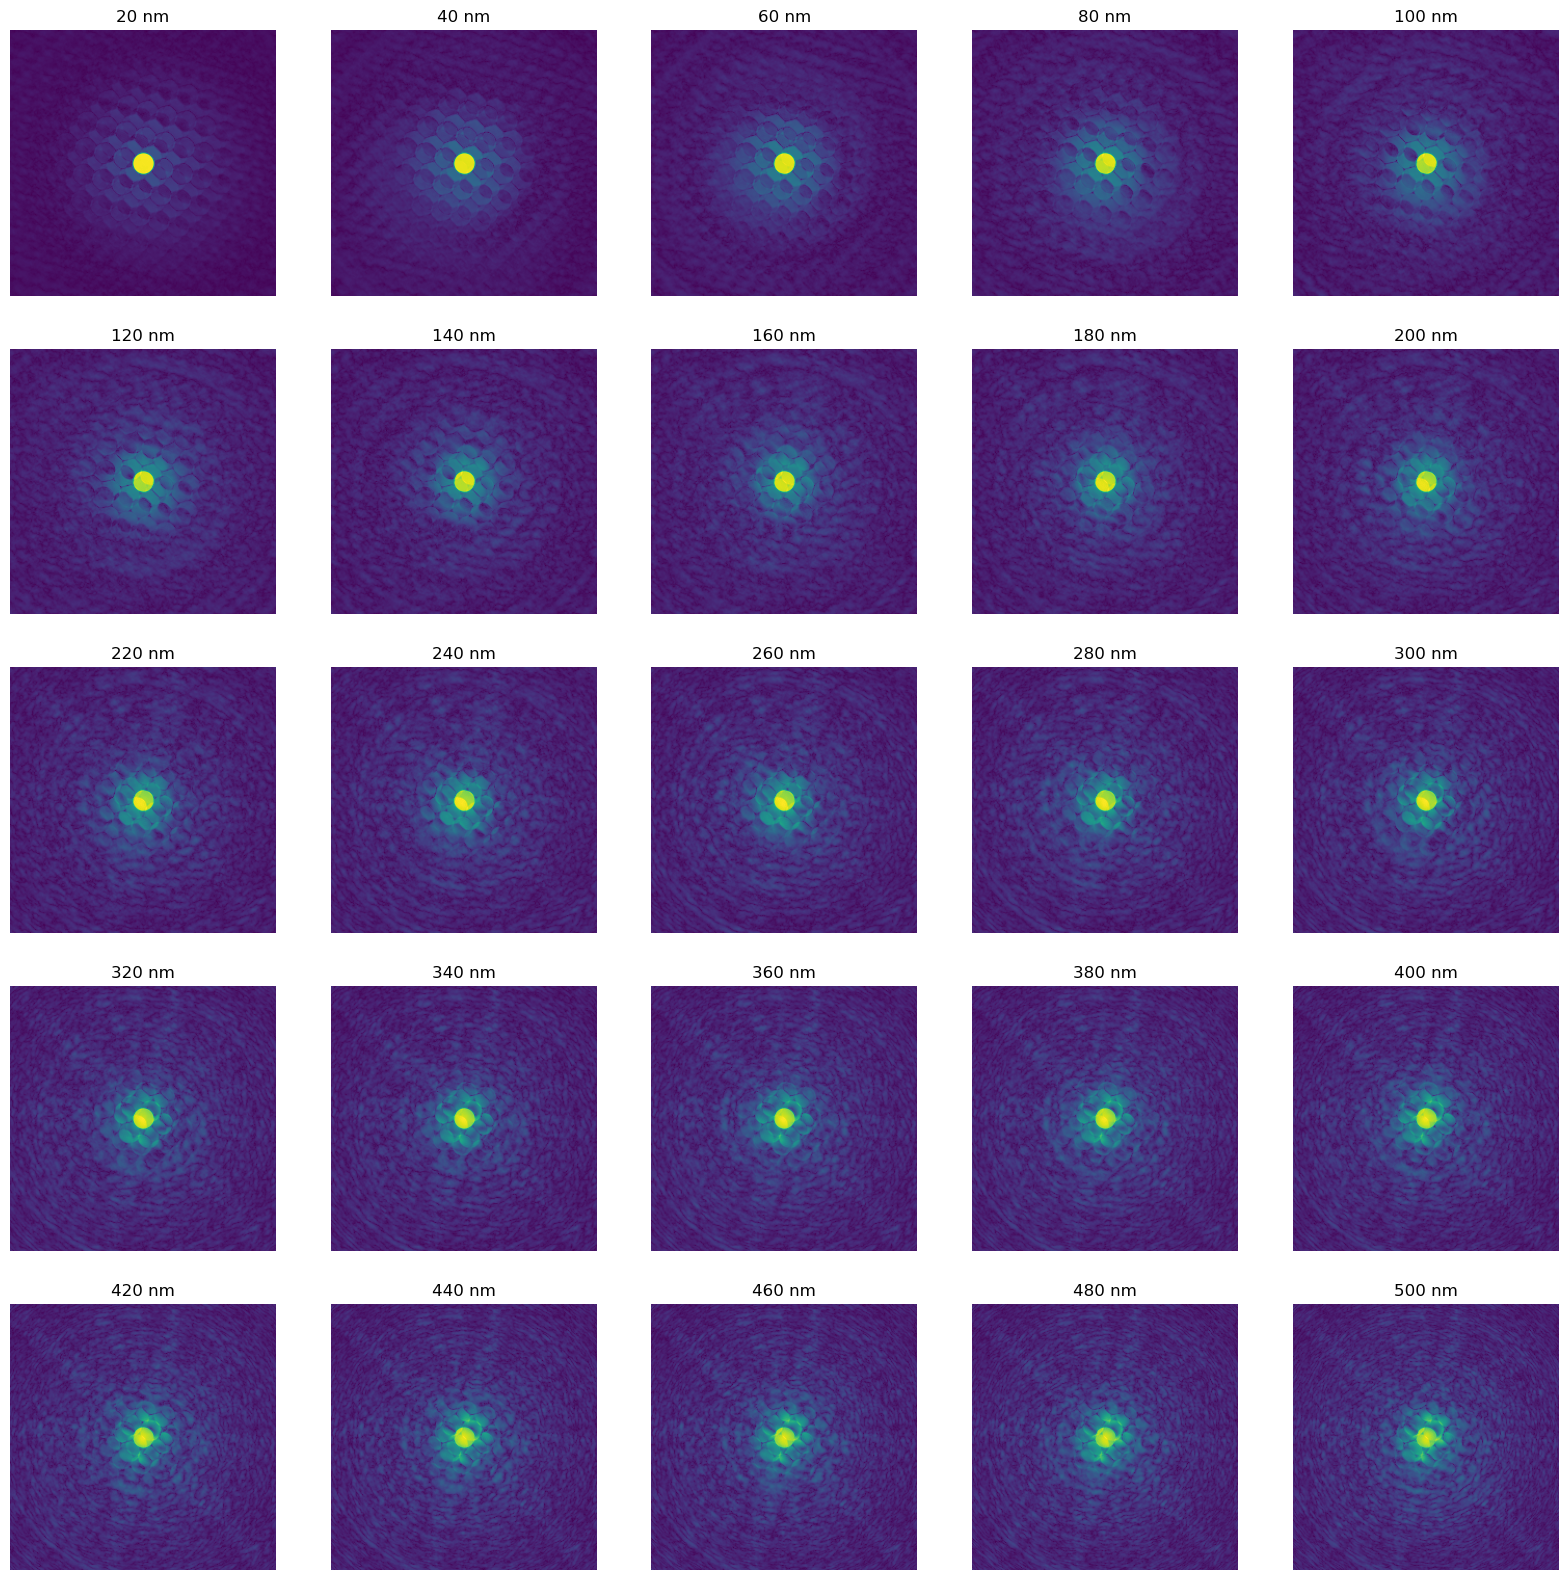

In [8]:
fig, ax = plt.subplots(5,5, figsize=(20,20))

axes = ax.ravel()

for i in range(25):
    axes[i].imshow(cbeds[...,i]**0.25)
    axes[i].set_title(f'{thicknesses[i]} nm')
    axes[i].set_axis_off()
    
plt.show()

In [70]:
augmentor = Image_Augmentation(
    background=True,
    shot=True,
    ellipticity=False,
    pattern_shift=True,
    xshift=1.1,
    yshift=35.5,
    counts_per_pixel=1e5,
    qBackgroundLorentz=0.1,
    weightbackground=0.1,
    salt_and_pepper=None,#1e-4,
    verbose=True,
    device='cpu',
)

The original augmentation for crystal4D expected the input shape to be:  
(batch, height, width, channel)  
this is logical, but it seems like the previous method augmented the entire batch using the same parameters (rather than a range of parameters), and this seems a bit odd to me. 

In [71]:
cbeds_input = np.transpose(cbeds, (2,1,0))[...,None]
print(cbeds_input.shape)
cbeds_aug = augmentor.augment_img(cbeds_input, probe[None,...,None])
cbeds_aug = np.transpose(cbeds_aug.squeeze(), (2,1,0))
cbeds_aug = np.clip(cbeds_aug, 1e-10, np.inf) 
print(cbeds_aug.shape)

(25, 256, 256, 1)
Printing augmentation summary... 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 
Shots per pixel: 100000.0 
Background plasmon: 0.1 
Ellipticity scaling: 0 
Pattern shift: 1.1,35.5 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 
Augmentation Status: it took 6.4e-03 minutes to augment 25 images...
(256, 256, 25)


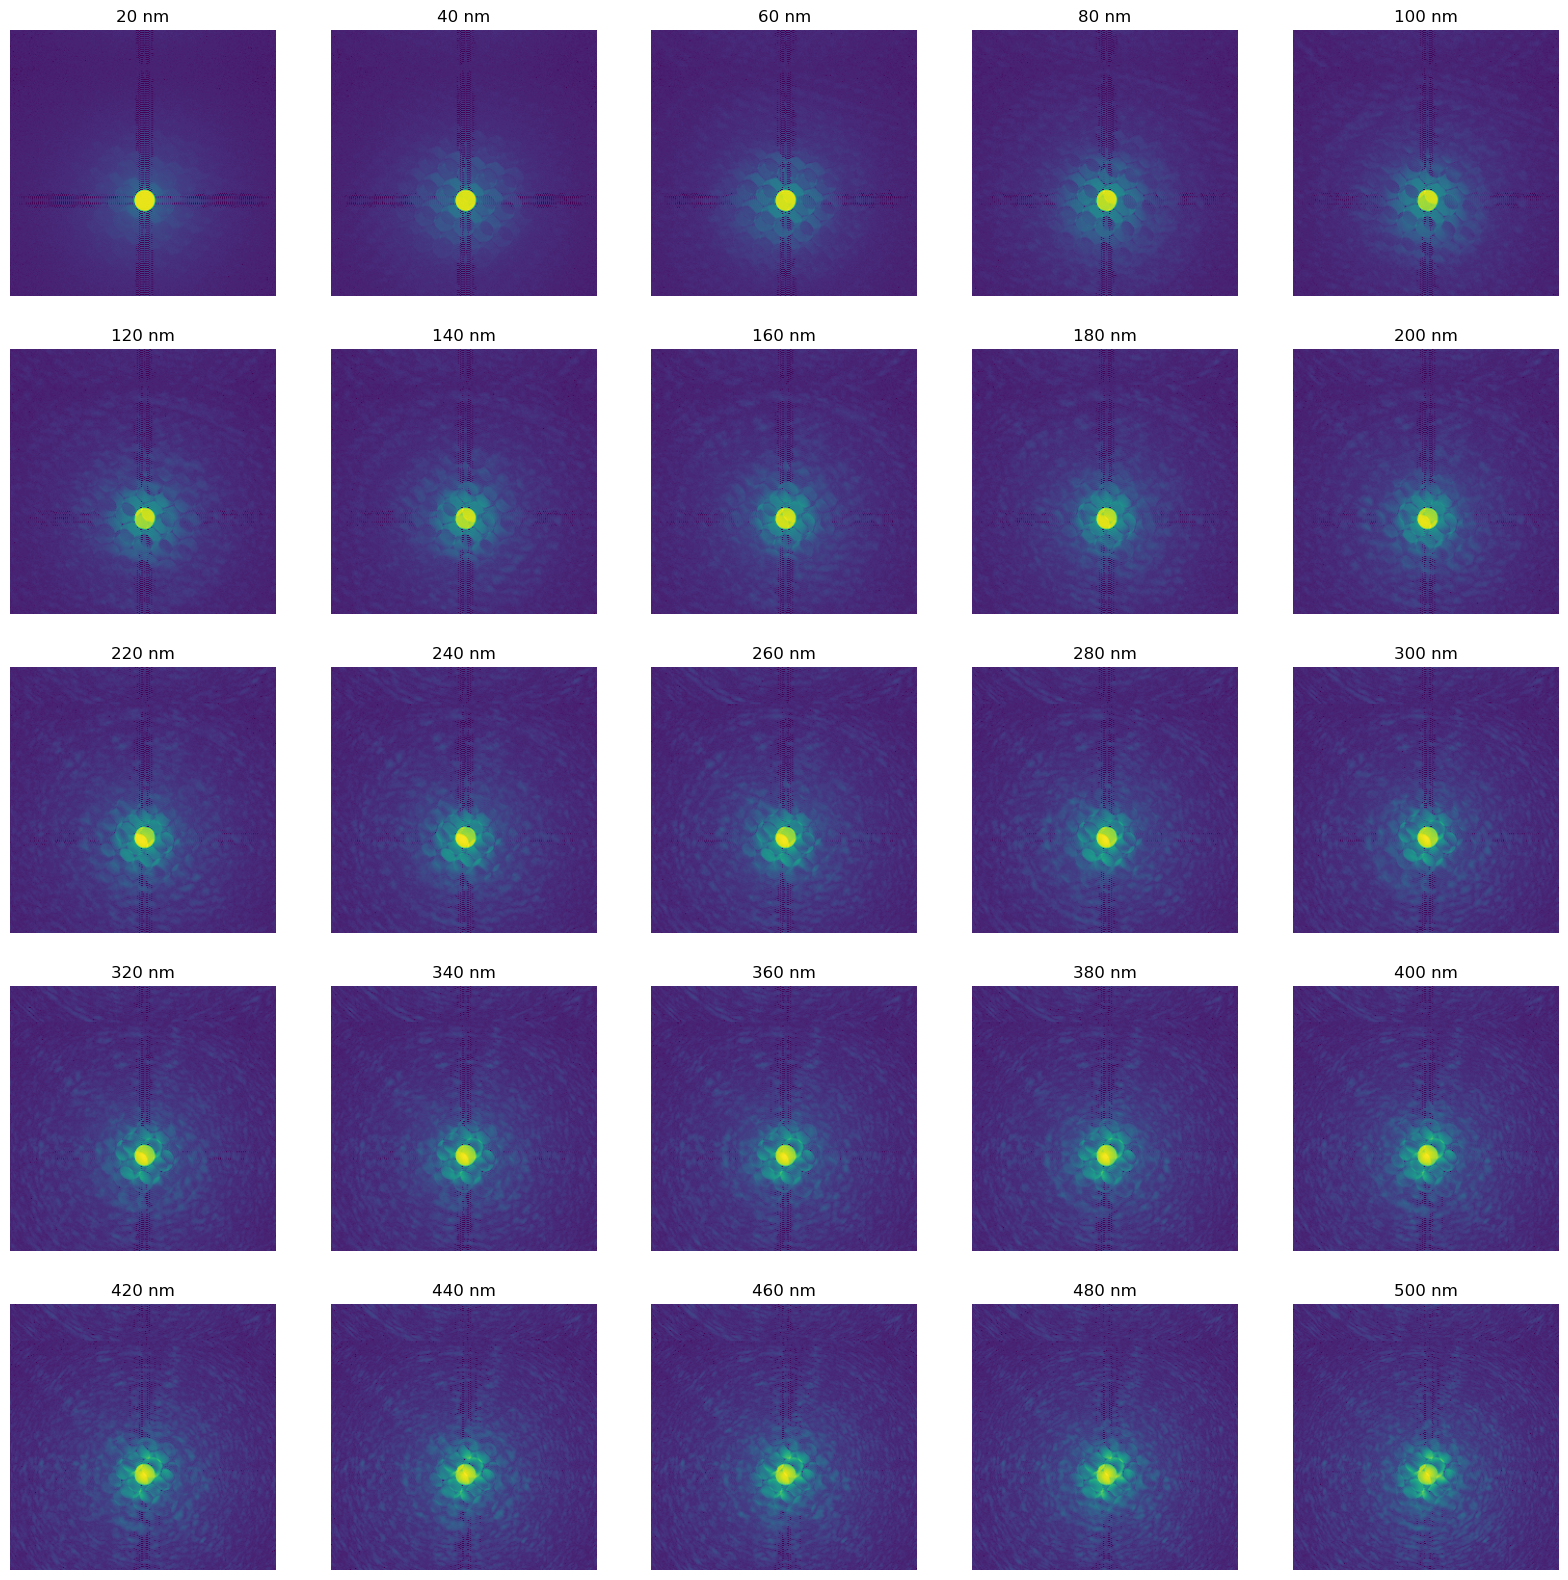

In [72]:
fig, ax = plt.subplots(5,5, figsize=(20,20))

axes = ax.ravel()

for i in range(25):
    axes[i].imshow(cbeds_aug[...,i]**0.25)
    axes[i].set_title(f'{thicknesses[i]} nm')
    axes[i].set_axis_off()
    
plt.show()

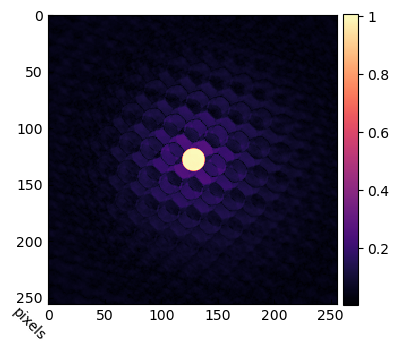

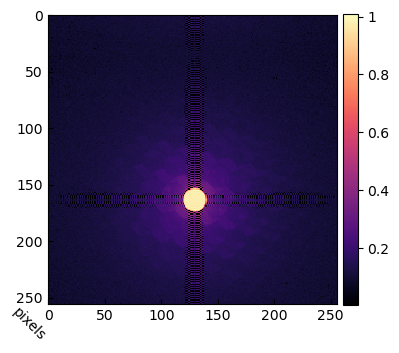

In [73]:

from hipl.utils import show_im
show_im(cbeds[...,0]**0.25, cmap='magma',)
show_im(cbeds_aug[...,0]**0.25, cmap='magma',)

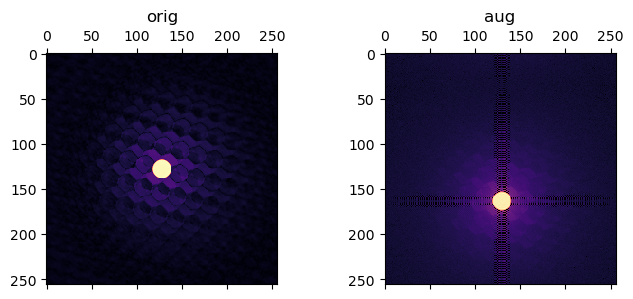

In [74]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3))
axs[0].matshow(cbeds[...,0]**0.25, cmap='magma')
axs[0].set_title("orig")

axs[1].matshow(cbeds_aug[...,0]**0.25, cmap='magma')
axs[1].set_title("aug")
plt.show()